In [1]:
import numpy as np
import pandas as pd
import time
import sys
import bitstring
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def keygenerate(q, m, n):
    s = np.random.randint(0, 2, (n))
    A = np.random.randint(0, q, (m, n))

    e = np.round(np.random.normal(loc=0, scale=q*0.01, size=m)).astype(int)
   
    print(e)
   
    b = (np.dot(A, s) + e) % q

    return (A, b), s

In [3]:
def encrypt(plaintext, publickey, q):
    A, b = publickey
    m = A.shape[0]
    ct = np.zeros(len(plaintext), dtype=object)
    for i in range(len(plaintext)):
        r = np.random.randint(0, 2, (m))
        a_prime = (np.dot(r, A)) % q
        if plaintext[i] == 0:
            b_prime = np.dot(r, b) % q
        elif plaintext[i] == 1:
            b_prime = (np.dot(r, b) + np.dot(plaintext[i], q//2)) % q

        ct[i] = (a_prime, b_prime)
    return ct

In [4]:
def decrypt(ciphertext, privatekey, q):
    privatekey = np.array(privatekey)
    pt = np.zeros(len(ciphertext), dtype=int)
    for i in range(len(ciphertext)):
        a_prime, b_prime = ciphertext[i]
        v = (np.dot(a_prime, privatekey)) 
        m_prime = abs(b_prime - v) % q

        diff0 = abs(m_prime - q)
        diff1 = abs(m_prime - q//2)
        
        if diff0 < diff1 or m_prime < diff1:
            pt[i] = 0
        elif diff0 > diff1:
            pt[i] = 1

    return pt

### Example

In [5]:
q = 2**13

publickey, s = keygenerate(q, 320, 320)

[ -71 -205  -11  260   38  -78  -79  -39   47   10   60  157   31  -76
   87   63   74    5  -34   79   44   -4  -24  -76   88  124   56  -84
   75   20  -79   54   65  -22   66  102  -25  -96  -89   -8 -104 -126
   75 -123  -59  124   13   83   62    2  -79    1   23 -100   11  -24
   39   24  -50  -87 -152 -127   28  -49   46 -115  -15  -50  -10   31
   74  -22  193  114  -63  -95   55  -23  -22  103   29  -62  115  -46
  -23   53   -7  158   64  -35   69   -2   60  -95  139    9   63   87
  -70   63   49   51 -108   31   44  120   88    0  152   36  -24  -82
  117 -112   51   77  -30 -140   79   99   44 -185   56 -125   17  117
   94  -77  -37   55 -104   42  125  -65  -10  -62  206   37    7   24
  -45  -79 -114  109   -1  -17 -126  -40 -102  -93    1    5  143 -118
   54   62  147    2  -20  155  108 -110    8  100  129  -19  -30  145
  -72 -144   29   37  -33    8  -48   15  -64   37 -111   99   78   -1
  108  194  -56   91    7  -21  140  105  -21   41   30  -50   78  -19
  166 

In [6]:
bits = [0, 1, 1, 0]
ct = encrypt(bits, publickey, q)
ct

array([(array([7752, 2457, 2554, 5048,  419,  644, 5146, 1409, 1584, 2338,  711,
              5362, 5356, 5310, 4871, 4767, 3040, 4140, 5050, 7018, 7206, 8058,
              5114, 4427, 3334, 5032, 3443, 5607, 2362, 3808, 1312, 5282, 4850,
               751, 4222, 5756, 2508, 2718, 3002, 4816, 8145, 7867, 6746, 1505,
               252,  469,  642, 2663, 2473, 1139,  638, 2270, 2918, 6641, 3444,
              7402, 2038, 3964,  596, 3450,  953, 1839, 1669, 4011, 3337, 1227,
              3745, 7473, 6973, 2681, 1398, 6419,  902, 1466,  118, 3915, 1514,
              7893, 7148, 2681, 1295, 7112,  538,  453, 7152, 7758, 3307,  849,
              5657, 3664, 1499, 5267, 2172, 1153, 6017, 5421, 7519, 4483, 1882,
              7318, 8147, 1609, 3685, 7554, 1516, 5885, 4071, 6640, 1111, 8007,
               594, 7189,  471, 3731, 4137, 1977, 7279, 4926, 5711, 3726, 2069,
              3087,  379, 5625,  808, 1126, 3636, 4066, 2206, 6285, 5341, 1163,
              3770, 1329, 4331, 3304, 7

In [7]:
pt = decrypt(ct, s, q)
pt

array([0, 1, 1, 0])

## Experiment on secured schemes

In [8]:
def UniformMod(q, n):  
    a = -(q // 2)
    b = -a - 1 if q % 2 == 0 else -a
    samples = np.random.randint(a, b + 1, n)
    return samples

def CenteredBinomial(eta, n):
    a = np.random.binomial(eta, 0.5, n)
    b = np.random.binomial(eta, 0.5, n)
    return a-b

def cal_size(ct, q):
    a, _ = ct[0]
    # number of elements of the matrix ct, len(a) is the len of a_prime and 1 is the length of b_prime
    elements_num = (len(a) + 1) * len(ct)
    # calculate number of bits needed for each element (with a range of 0 to q-1)
    size = elements_num * np.ceil(np.log2(q))
    # convert to bytes
    size /= 8
    return size

In [9]:
encryption_time = []
ct_size = []
schemes = ["Kyber512", "Kyber768", "Kyber1024", "LightSaber", "Saber", "FireSaber", "Frodo640", "Frodo976", "Frodo1344"]
# shortest estimated time to break the schemes in the power of two
security = [140.3, 201.0, 270.8, 140.1, 208.2, 275.8, 163.0, 225.2, 287.9]

# plaintext to encrypt on is an array of binary of 10bits
pt = np.random.randint(0, 2, 10)
pt

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 1])

### Kyber 512

In [10]:
# configurations
n=2 * 256
q=3329
Xs=CenteredBinomial(3, n)
Xe=CenteredBinomial(3, n)
m=2 * 256

A = np.random.randint(0, q, (m, n))
b = (np.dot(A, Xs) + Xe) % q

In [11]:
start = time.time()
# encrypt 10 times and returns the average
for i in range(10):
    ct = encrypt(pt, (A, b), q)
time_needed = (time.time() - start) / 10
print(time_needed)
encryption_time.append(time_needed)
size = cal_size(ct, q)
print(size)
ct_size.append(size)

0.008863687515258789
7695.0


In [12]:
output = np.array(decrypt(ct, Xs, q))
assert np.array_equal(pt, output)

### Kyber 768

In [13]:
n=3 * 256
q=3329
Xs=CenteredBinomial(2, n)
Xe=CenteredBinomial(2, n)
m=3 * 256

A = np.random.randint(0, q, (m, n))
b = (np.dot(A, Xs) + Xe) % q

In [14]:
start = time.time()
for i in range(10):
    ct = encrypt(pt, (A, b), q)
time_needed = (time.time() - start) / 10
print(time_needed)
encryption_time.append(time_needed)
size = cal_size(ct, q)
print(size)
ct_size.append(size)

0.017716431617736818
11535.0


In [15]:
output = np.array(decrypt(ct, Xs, q))
assert np.array_equal(pt, output)

### Kyber 1024

In [16]:
n=4 * 256
q=3329
Xs=CenteredBinomial(2, n)
Xe=CenteredBinomial(2, n)
m=4 * 256

A = np.random.randint(0, q, (m, n))
b = (np.dot(A, Xs) + Xe) % q

In [17]:
start = time.time()
for i in range(10):
    ct = encrypt(pt, (A, b), q)
time_needed = (time.time() - start) / 10
print(time_needed)
encryption_time.append(time_needed)
size = cal_size(ct, q)
print(size)
ct_size.append(size)

0.05190322399139404
15375.0


In [18]:
output = np.array(decrypt(ct, Xs, q))
assert np.array_equal(pt, output)

### LightSaber

In [19]:
n=2 * 256
q=8192
Xs=CenteredBinomial(5, n)
Xe=UniformMod(8, n)
m=2 * 256

A = np.random.randint(0, q, (m, n))
b = (np.dot(A, Xs) + Xe) % q

In [20]:
start = time.time()
for i in range(10):
    ct = encrypt(pt, (A, b), q)
time_needed = (time.time() - start) / 10
print(time_needed)
encryption_time.append(time_needed)
size = cal_size(ct, q)
print(size)
ct_size.append(size)

0.009805536270141602
8336.25


In [21]:
output = np.array(decrypt(ct, Xs, q))
assert np.array_equal(pt, output)

### Saber

In [22]:
n=3 * 256
q=8192
Xs=CenteredBinomial(4, n)
Xe=UniformMod(8, n)
m=3 * 256

A = np.random.randint(0, q, (m, n))
b = (np.dot(A, Xs) + Xe) % q

In [23]:
start = time.time()
for i in range(10):
    ct = encrypt(pt, (A, b), q)
time_needed = (time.time() - start) / 10
print(time_needed)
encryption_time.append(time_needed)
size = cal_size(ct, q)
print(size)
ct_size.append(size)

0.019374680519104005
12496.25


In [24]:
output = np.array(decrypt(ct, Xs, q))
assert np.array_equal(pt, output)

### FireSaber

In [25]:
n=4 * 256
q=8192
Xs=CenteredBinomial(3, n)
Xe=UniformMod(8, n)
m=4 * 256

A = np.random.randint(0, q, (m, n))
b = (np.dot(A, Xs) + Xe) % q

In [26]:
start = time.time()
for i in range(10):
    ct = encrypt(pt, (A, b), q)
time_needed = (time.time() - start) / 10
print(time_needed)
encryption_time.append(time_needed)
size = cal_size(ct, q)
print(size)
ct_size.append(size)

0.03796250820159912
16656.25


In [27]:
output = np.array(decrypt(ct, Xs, q))
assert np.array_equal(pt, output)

### Frodo 640

In [28]:
n=640
q=2**15
m=640 + 16
Xs=np.round(np.random.normal(0, 2.8, n)).astype(int)
Xe=np.round(np.random.normal(0, 2.8, m)).astype(int)

A = np.random.randint(0, q, (m, n))
b = (np.dot(A, Xs) + Xe) % q

In [29]:
start = time.time()
for i in range(10):
    ct = encrypt(pt, (A, b), q)
time_needed = (time.time() - start) / 10
print(time_needed)
encryption_time.append(time_needed)
size = cal_size(ct, q)
print(size)
ct_size.append(size)

0.009429359436035156
12018.75


In [30]:
output = np.array(decrypt(ct, Xs, q))
assert np.array_equal(pt, output)

### Frodo 976

In [31]:
n=976
q=2**16
m=976 + 16
Xs=np.round(np.random.normal(0, 2.3, n)).astype(int)
Xe=np.round(np.random.normal(0, 2.3, m)).astype(int)

A = np.random.randint(0, q, (m, n))
b = (np.dot(A, Xs) + Xe) % q

In [32]:
start = time.time()
for i in range(10):
    ct = encrypt(pt, (A, b), q)
time_needed = (time.time() - start) / 10
print(time_needed)
encryption_time.append(time_needed)
size = cal_size(ct, q)
print(size)
ct_size.append(size)

0.023816132545471193
19540.0


In [33]:
output = np.array(decrypt(ct, Xs, q))
assert np.array_equal(pt, output)

### Frodo 1344

In [34]:
n=1344
q=2**16
m=1344 + 16
Xs=np.round(np.random.normal(0, 1.4, n)).astype(int)
Xe=np.round(np.random.normal(0, 1.4, m)).astype(int)

A = np.random.randint(0, q, (m, n))
b = (np.dot(A, Xs) + Xe) % q

In [35]:
start = time.time()
for i in range(10):
    ct = encrypt(pt, (A, b), q)
time_needed = (time.time() - start) / 10
print(time_needed)
encryption_time.append(time_needed)
size = cal_size(ct, q)
print(size)
ct_size.append(size)

0.0468388557434082
26900.0


In [36]:
output = np.array(decrypt(ct, Xs, q))
assert np.array_equal(pt, output)

## Outputting the results

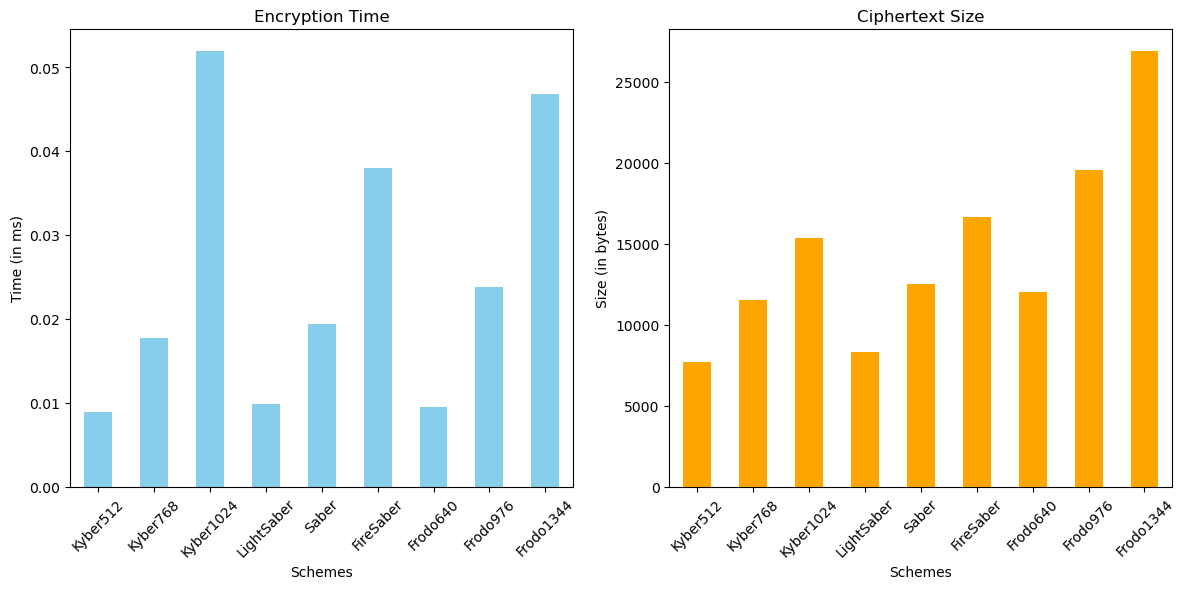

In [37]:
df = pd.DataFrame({
    'Time(in ms)': encryption_time,
    'Size(in bytes)': ct_size,
    'Security(in bits)': security
}, index=schemes)

# Plotting graph
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot time data
df['Time(in ms)'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Encryption Time')
axes[0].set_ylabel('Time (in ms)')
axes[0].set_xlabel('Schemes')
axes[0].tick_params(axis='x', rotation=45)

# Plot size data
df['Size(in bytes)'].plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Ciphertext Size')
axes[1].set_ylabel('Size (in bytes)')
axes[1].set_xlabel('Schemes')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

C:\Users\Haygen Tsoi\AppData\Local\Temp\ipykernel_4484\483558582.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[0].annotate(txt, (df['Security(in bits)'][i], df['Time(in ms)'][i]))
C:\Users\Haygen Tsoi\AppData\Local\Temp\ipykernel_4484\483558582.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[1].annotate(txt, (df['Security(in bits)'][i], df['Size(in bytes)'][i]))


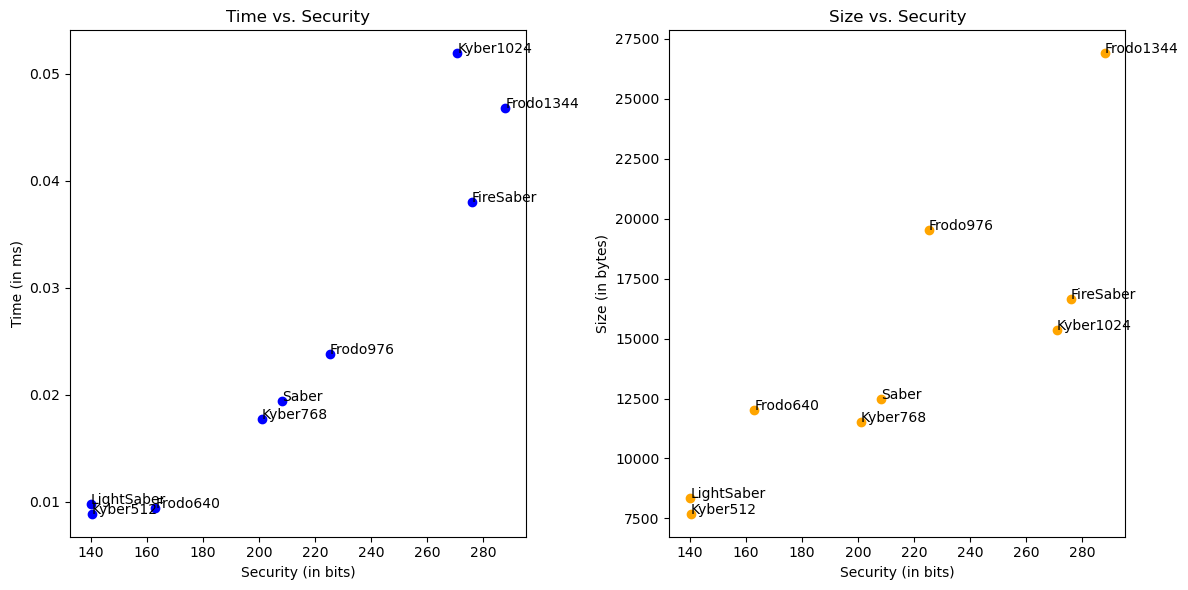

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot 'Time(in ms)' vs. 'Security(in bits)'
axes[0].scatter(df['Security(in bits)'], df['Time(in ms)'], color='blue')
axes[0].set_title('Time vs. Security')
axes[0].set_xlabel('Security (in bits)')
axes[0].set_ylabel('Time (in ms)')

for i, txt in enumerate(schemes):
    axes[0].annotate(txt, (df['Security(in bits)'][i], df['Time(in ms)'][i]))

# Plot 'Size(in bytes)' vs. 'Security(in bits)'
axes[1].scatter(df['Security(in bits)'], df['Size(in bytes)'], color='orange')
axes[1].set_title('Size vs. Security')
axes[1].set_xlabel('Security (in bits)')
axes[1].set_ylabel('Size (in bytes)')

for i, txt in enumerate(schemes):
    axes[1].annotate(txt, (df['Security(in bits)'][i], df['Size(in bytes)'][i]))


plt.tight_layout()
plt.show()


In [39]:
print(encryption_time)
print(ct_size)

[0.008863687515258789, 0.017716431617736818, 0.05190322399139404, 0.009805536270141602, 0.019374680519104005, 0.03796250820159912, 0.009429359436035156, 0.023816132545471193, 0.0468388557434082]
[7695.0, 11535.0, 15375.0, 8336.25, 12496.25, 16656.25, 12018.75, 19540.0, 26900.0]
